# Titanic Survival Analysis

In the early hours of the morning of 15 April 1912, the RMS Titanic sank on its maiden voyage across the Atlantic Ocean 
after it struck an iceberg. As part of an independent investigation into the tragedy, you are tasked with analysing the
survival logs for passengers aboard the Titanic.

The purpose of this notebook it to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The components of this analysis will include:
1. Exploritory Data Analysis
2. Data Cleaning
3. Data Modeling
4. Data Prediction

## Dataset Description

We have a training and test csv.

For the training set, we have the ground truth of whether each passenger survivors. 
The test set should be used to see how well your model performs on unseen data.


| Variable | Definition | Description |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class (proxy for socio-economic status) | 1 = Upper, 2 = Middle, 3 = Lower |
| sex | Sex of Passemger | male/female |
| Age | Age in years | Integer (Example: 25) |
| sibsp | # of siblings / spouses aboard the Titanic | Integer (Example: 2) |
| parch | # of parents / children aboard the Titanic | Integer (Example: 1) |
| ticket | Ticket number | Str (Example: "SC/Paris 2123") |
| fare | Passenger fare | Float (Example: 41.5792)|
| cabin | Cabin number | Str (Example: "B78")|
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### Additional Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way..\n
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import xgboost as xg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error

### Load in the data

In [2]:
# Survived
data_dir = "data"
train_path = os.path.join(data_dir, "train.csv")

train_df = pd.read_csv(train_path)
print(f"Train df: {train_df.shape}\n")
train_df.head()

Train df: (891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_path = os.path.join(data_dir, "test.csv")

test_df = pd.read_csv(test_path)
print(f"Test df: {test_df.shape}\n")
test_df.head()

Test df: (418, 11)



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
total_data = len(test_df) + len(train_df)
print(f"Train split: {len(train_df)/total_data*100:.0f}%")
print(f"Test split:  {len(test_df)/total_data*100:.0f}%")

Train split: 68%
Test split:  32%


## 1. Expoloritory Data Analysis

### 1.1 Univarient Analysis

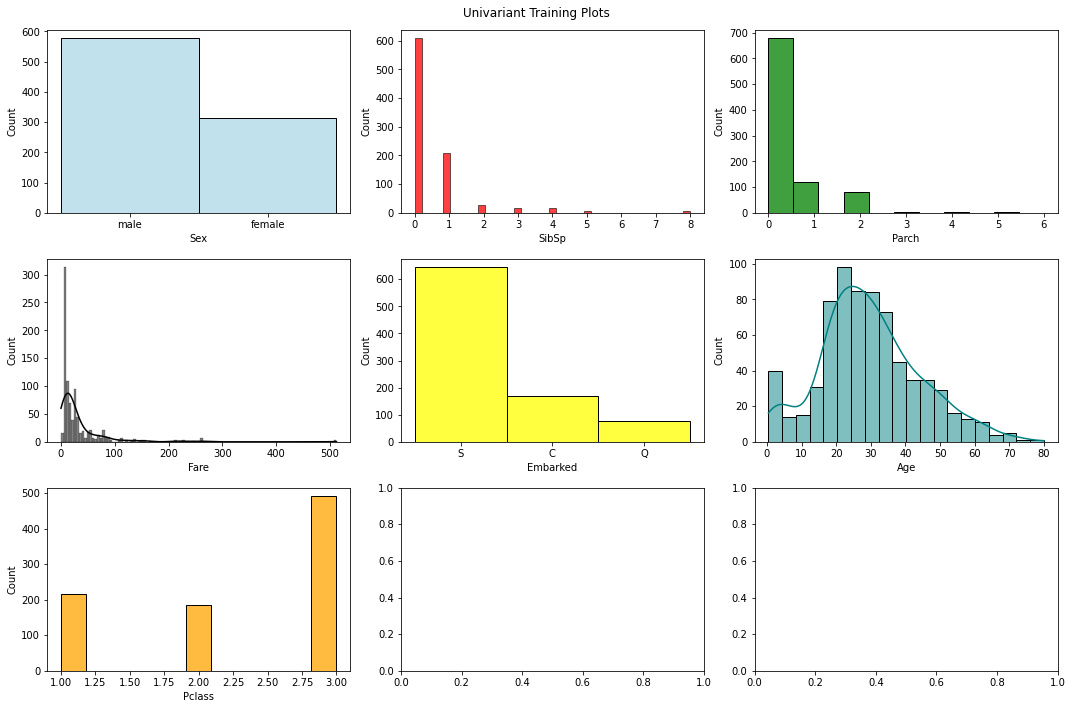

In [7]:
# Univarient Analysis

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

sns.histplot(data=train_df, x="Sex", kde=False, color="lightblue", ax=axs[0, 0])
sns.histplot(data=train_df, x="SibSp", kde=False, color="red", ax=axs[0, 1])
sns.histplot(data=train_df, x="Parch", kde=False, color="green", ax=axs[0, 2])
sns.histplot(data=train_df, x="Fare", kde=True, color="black", ax=axs[1, 0])
sns.histplot(data=train_df, x="Embarked", kde=False, color="yellow", ax=axs[1, 1])
sns.histplot(data=train_df, x="Age", kde=True, color="teal", ax=axs[1, 2])
sns.histplot(data=train_df, x="Pclass", kde=False, color="orange", ax=axs[2, 0])

plt.suptitle("Univariant Training Plots")
plt.tight_layout()
plt.show()

In [8]:
for var in list(train_df["Sex"].unique()):
    avg_age = train_df[train_df['Sex']==var]['Age'].mean().round(0)
    print(f"Average age of a {var} passenger:",avg_age)

Average age of a male passenger: 31.0
Average age of a female passenger: 28.0


Text(0.5, 1.05, 'Bar Chart of Survival Rate grouped by Sex')

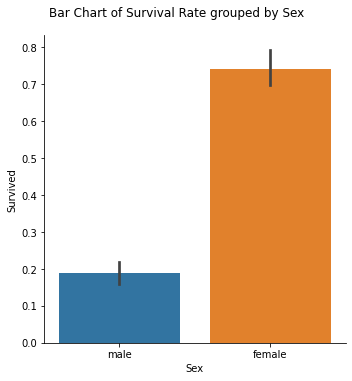

In [9]:
g = sns.catplot(data=train_df, x="Sex", y="Survived", kind="bar")
g.fig.suptitle("Bar Chart of Survival Rate grouped by Sex", y=1.05)

#### Observations
- 2 Thirds more Males then females
- 3 extremely large fare price of 512 dollars. These are owned by first class citizens and are luxury suites.
- Children who are younger than 1 have a fraction as their age - round to an integer 
- Most people embarked from Southampton
- Third class passengers make up half of the people on-board and there are more first class passengers compared to second class
- 20% of all males did not survive

### 1.2 Multivariate Analysis

Text(0.5, 1.05, 'Bar Chart of Survival Rate vs Class grouped by Sex')

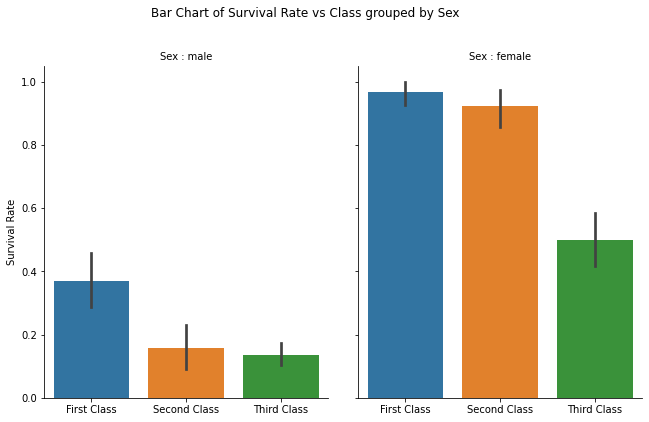

In [10]:
g = sns.catplot(
    data=train_df, x="Pclass", y="Survived", col="Sex",
    kind="bar", height=4, aspect=.6,
)
g.fig.set_size_inches(10,6)
g.set_axis_labels("", "Survival Rate")
g.set_xticklabels(["First Class", "Second Class", "Third Class"])
g.set_titles("{col_var} : {col_name}")
g.fig.suptitle("Bar Chart of Survival Rate vs Class grouped by Sex", y=1.05)

## Observations
- More than 90%  of First and Second class feamles survived. Only 50% of females from thrid class survived.
- We see similair proportions of 50% smaller survival rates for second and third class when compared to first class.

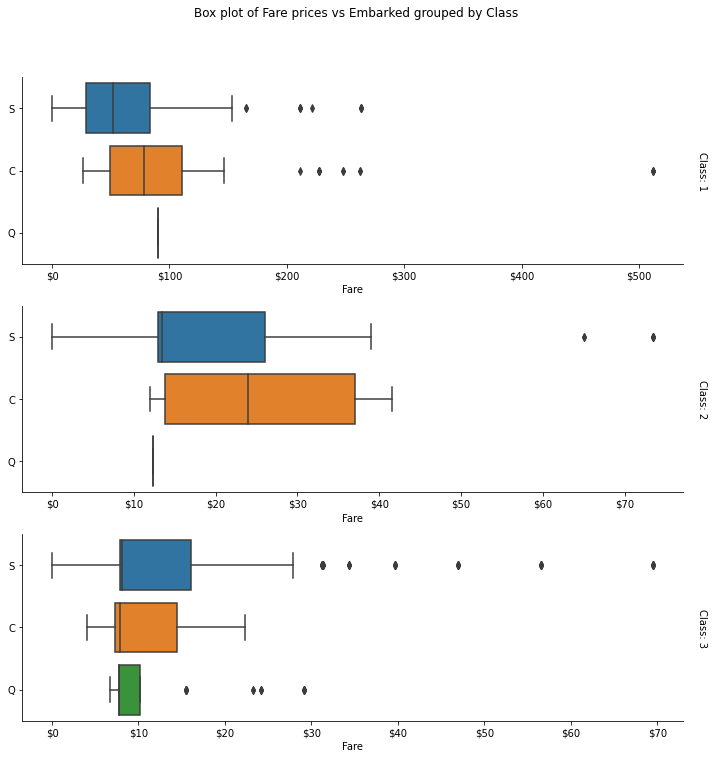

In [11]:
g = sns.catplot(
    data=train_df,
    x="Fare", y="Embarked",
    row="Pclass",
    kind="box", 
    orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Fare", ylabel="")
g.fig.set_size_inches(10,10)
g.set_titles(row_template="Class: {row_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('${x:.0f}')
    
g.fig.suptitle("Box plot of Fare prices vs Embarked grouped by Class", y=1.05)
plt.tight_layout()

## 2. Data Cleaning

In [12]:
# Correct all young childrens age to 1 year old instead of having a fraction
train_df.loc[train_df["Age"] < 1, "Age"] = 1

In [13]:
print(f"Perentage of data null (out of {train_df.shape[0]} rows):")
train_df.isnull().sum() / train_df.shape[0] * 100

Perentage of data null (out of 891 rows):


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

# Nul Data Result (Do for test as well)
**Cabin (~77%)**
We see that 77% of Cabin feature is Null. Consider removing the column completely

**Age (~20%)**
We see that the continious variable age is missing 20% of its data. Options:
- Create a model which can predict age using (possibly using [Sex, SibSp, Parch])
- We could just apply the mean age of male or female

**Embarked (>1%)**
- Since this is such a small proportion of the data we can just fill with an aggregate metric (mean) 

In [14]:
# Remove Cabin

train_df.drop(columns="Cabin", inplace=True, errors='ignore')
assert "Cabin" not in train_df.columns

test_df.drop(columns="Cabin", inplace=True, errors='ignore')
assert "Cabin" not in test_df.columns

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

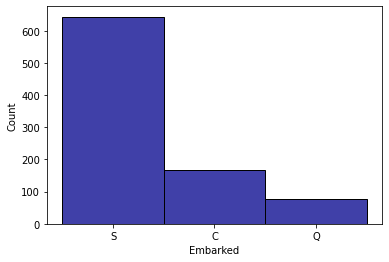

In [15]:
# Fill Embarged with Aggregate

sns.histplot(data=train_df, x="Embarked", kde=False, color="darkblue")

In [16]:
train_df["Embarked"].fillna(value="S", inplace=True)
test_df["Embarked"].fillna(value="S", inplace=True)

In [17]:
train_df["Embarked"].isnull().sum(), test_df["Embarked"].isnull().sum()

(0, 0)

### Predict Age (Sub-prediction task)

Note: We should not use or test data to infer this - but instead create a validation set for tuning this model

Look at most correlated features to base the prediction off

In [18]:
# Drop passenger-id
continious_train_df = train_df.drop(columns="PassengerId")
# Convert Sex to continious data type
sex_cts_dict = {
    'male': 0,
    'female': 1
}
continious_train_df["Sex"] = continious_train_df["Sex"].apply(lambda x: sex_cts_dict[x])

# Convert Embarked to continious data type
embarked_cts_dict = {
    'S': 0,
    'C': 1,
    'Q': 2
}
continious_train_df["Embarked"] = train_df["Embarked"].apply(lambda x: embarked_cts_dict[x])

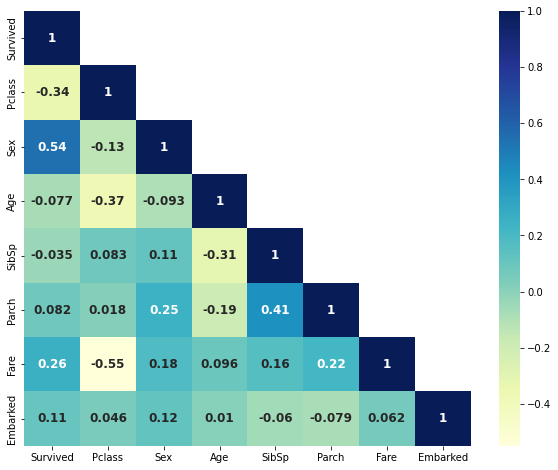

In [19]:
# creating mask
mask = np.triu(np.ones_like(continious_train_df.corr()))
mask[np.diag_indices_from(mask)] = False

fig, ax = plt.subplots(figsize=(10, 8))

# plotting correlation heatmap
a = sns.heatmap(
    continious_train_df.corr(), cmap="YlGnBu", annot=True, mask=mask, ax=ax,
    annot_kws= {'fontsize': 12, 'fontweight': 'bold'}

)
plt.show()

**Results**
This correlation heatmap shows us that their are no singular standout features which has a high correlation to Age. Pclass and SibSp do have a moderate negative correlation of -0.37 and -0.31 respectively. Perhaps we need to investigate how interaction terms may play a role in this data.

Note: Sex has a correlation of 0.54 which supports the data showing that males have 

### Using a Ordinary Least Squares Model identify which feature explain Age

In [20]:
model = ols('Age ~ Sex * Pclass * SibSp', data=train_df).fit()

# Type 1 ANOVA DataFrame
table_type_1 = sm.stats.anova_lm(model, typ=1) 
table_type_1

,df,sum_sq,mean_sq,F,PR(>F)
Sex,1.0,1309.355436,1309.355436,8.063982,4.645287e-03
Pclass,1.0,22695.333937,22695.333937,139.774706,1.487321e-29
Sex:Pclass,1.0,41.273945,41.273945,0.254196,6.142935e-01
SibSp,1.0,10877.060044,10877.060044,66.989006,1.273815e-15
Sex:SibSp,1.0,588.242226,588.242226,3.622832,5.739821e-02
Pclass:SibSp,1.0,153.255620,153.255620,0.943862,3.316194e-01
Sex:Pclass:SibSp,1.0,52.636149,52.636149,0.324172,5.692920e-01
Residual,706.0,114633.800626,162.370822,NaN,NaN


**Results**: From the above table we see that the interactions terms between Sex:Pclass and Pclass:SibSp do a good job at explaining Age.
Sex is the standout single variable which explains Age out of the three individual variables. Since Pclass and Sex seem to logically make sense to predict age. I will use those features.

In [21]:
# Previous Rule based Age predictor

def predict_age_rule_based(df):
    null_df = df[df["Age"].isnull()]
    print(null_df.shape)
    non_null_df = df[~df["Age"].isnull()]
    print(non_null_df.shape)
    
    for (sex, pclass), nn_df in non_null_df.groupby(["Sex", "Pclass"]):
        avg_age = int(np.nanmedian(nn_df["Age"]))
        null_df.loc[(null_df["Sex"] == sex) & (null_df["Pclass"] == pclass), "Age"] = avg_age
        print(f"Mean age for {sex}:{pclass} = {avg_age:.2f}")
    
    return pd.concat([null_df, non_null_df])
        

In [22]:
def convert_to_categorical(df, columns):
    """
    input: dataframe and col list of categorical columns
    output: dataframw with numerical values
    """
    df_ = df.copy()
    for col in columns:
        if df_[col].dtype != "object":
            print(f"Skipping column {col} due to dtype")
            continue
            
        item_list = df_[col].unique().tolist()
        enum = enumerate(item_list)
        d = dict((j,i) for i,j in enum)
        print(col)
        print(d)
        df_[col].replace(d, inplace=True)
        
    return df_


def predict_age_xgboost(df):
    columns = ["Sex", "Embarked"]

    null_df = df[df["Age"].isnull()]
    null_df = convert_to_categorical(null_df, columns)
    print("null_df.shape: ", null_df.shape)
    
    non_null_df = df[~df["Age"].isnull()]
    non_null_df = convert_to_categorical(non_null_df, columns)
    print("non_null_df.shape: ", non_null_df.shape)
    
    train_X = non_null_df[["Sex", "Pclass", "SibSp"]]
    train_y = non_null_df["Age"]
    test_X = null_df[["Sex", "Pclass", "SibSp"]]

    # Instantiation
    xgb_r = xg.XGBRegressor(
        n_estimators = 10,
        seed = 144
    )
    # Fitting the model
    xgb_r.fit(train_X, train_y)

    # Predict the model
    pred = xgb_r.predict(test_X)
    pred = np.round(pred)
    
    null_df["Age"] = pred
    
    full_df = pd.concat([null_df, non_null_df])
    
    return df.drop(columns="Age").merge(full_df[["PassengerId", "Age"]], on="PassengerId")


In [23]:
train_df = predict_age_xgboost(train_df)
train_df.shape

Sex
{'male': 0, 'female': 1}
Embarked
{'Q': 0, 'S': 1, 'C': 2}
null_df.shape:  (177, 11)
Sex
{'male': 0, 'female': 1}
Embarked
{'S': 0, 'C': 1, 'Q': 2}
non_null_df.shape:  (714, 11)


(891, 11)

In [24]:
train_df["Age"].isnull().sum()

0

In [25]:
# Save augmented train data
augumented_training_data = "data/augmented_train.csv"
train_df.to_csv(augumented_training_data, index=False)
print(f"Saved training data successfully too: {augumented_training_data}")

Saved training data successfully too: data/augmented_train.csv


### Look into test DF

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


In [27]:
test_df = predict_age_xgboost(test_df)
test_df.shape

Sex
{'male': 0, 'female': 1}
Embarked
{'S': 0, 'C': 1, 'Q': 2}
null_df.shape:  (86, 10)
Sex
{'male': 0, 'female': 1}
Embarked
{'Q': 0, 'S': 1, 'C': 2}
non_null_df.shape:  (332, 10)


(418, 10)

In [28]:
test_df["Age"].isnull().sum()

0

In [29]:
# Save augmented test data

augumented_test_data = "data/augmented_test.csv"
test_df.to_csv(augumented_test_data, index=False)
print(f"Saved training data successfully too: {augumented_test_data}")

Saved training data successfully too: data/augmented_test.csv


In [30]:
test_df.shape

(418, 10)